In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

In [20]:
token = os.path.join(os.environ['HOME'],'code/cel/auth/spacescope_auth.json')

# Simulation parameters
forecast_start_date = date.today() - timedelta(days=3)
current_date = forecast_start_date

start_date = current_date - timedelta(days=3) # get some historical data
current_day = (current_date-start_date).days
forecast_length = 365*6
end_date = current_date + timedelta(days=forecast_length)

## FIP implementation parameters
# update_day = pd.to_datetime('2024-09-01')
update_day = pd.to_datetime('2024-03-01')


In [21]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/baseline_bugfix')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [22]:
pystarboard.data.setup_spacescope(token)

In [23]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

In [24]:
#reconstruct historical power onboarding/pledge/fofr metrics
hist_df = pystarboard.data.get_historical_network_stats(start_date-timedelta(days=360), current_date, end_date)
hist_expire_df = pystarboard.data.query_sector_expirations(start_date-timedelta(days=360), current_date)

In [25]:
hist_df['date'] = pd.to_datetime(hist_df['date'])
hist_df.sort_values('date', inplace=True)
hist_expire_df['date'] = pd.to_datetime(hist_expire_df['date']).dt.tz_localize(None)
hist_expire_df.sort_values('date', inplace=True)
hist_df_merged = pd.merge_asof(hist_df, hist_expire_df, on='date')

hist_econ_df = pystarboard.data.query_sector_economics(
    start_date-timedelta(days=360), 
    current_date, 
)
pledge_historical = hist_econ_df[['date', 'sector_initial_pledge_32gib']]
pledge_historical['date'] = pd.to_datetime(pledge_historical['date'])
    
hist_df_merged = pd.merge_asof(hist_df_merged, pledge_historical, on='date')

/tmp/ipykernel_52190/1822774717.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pledge_historical['date'] = pd.to_datetime(pledge_historical['date'])


In [26]:
# now add the quantities of interest
hist_df_merged['day_network_reward'] = hist_df_merged['mined_fil'].diff()
hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]
hist_df_merged['day_locked_pledge'] = hist_df_merged['locked_fil'].diff()
hist_df_merged['day_renewed_pledge'] = hist_df_merged['extended_pledge'].diff()

hist_df_merged['day_rewards_per_sector'] = C.EIB_PER_SECTOR * hist_df_merged['day_network_reward'] / hist_df_merged['total_qa_power_eib']

/tmp/ipykernel_52190/575488602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]


In [27]:
# show the difference between smooth ramp-up of pledge vs. sudden increase
# by modeling the gamma parameter as a vector that switches from 1 to 0.7 as a step function vs. a smooth ramp
no_gamma = np.ones(forecast_length)

gamma_today = np.ones(forecast_length)*0.7

gamma_sharp = np.ones(forecast_length)
forecast_t = pd.date_range(current_date, periods=forecast_length, freq='D')
gamma_sharp[forecast_t >= update_day] = 0.7

gamma_smooth_1y = np.ones(forecast_length)
update_day_start = update_day
update_day_end = update_day + timedelta(days=360)
ramp_gamma = np.linspace(1, 0.7, (update_day_end-update_day_start).days)
ramp_start_idx = (update_day_start-pd.to_datetime(current_date)).days
ramp_end_idx = (update_day_end-pd.to_datetime(current_date)).days
gamma_smooth_1y[ramp_start_idx:ramp_end_idx] = ramp_gamma
gamma_smooth_1y[ramp_end_idx:] = 0.7

gamma_smooth_2y = np.ones(forecast_length)
update_day_start = update_day
update_day_end = update_day + timedelta(days=730)
ramp_gamma = np.linspace(1, 0.7, (update_day_end-update_day_start).days)
ramp_start_idx = (update_day_start-pd.to_datetime(current_date)).days
ramp_end_idx = (update_day_end-pd.to_datetime(current_date)).days
gamma_smooth_2y[ramp_start_idx:ramp_end_idx] = ramp_gamma
gamma_smooth_2y[ramp_end_idx:] = 0.7

gamma_smooth_3y = np.ones(forecast_length)
update_day_start = update_day
update_day_end = update_day + timedelta(days=365*3)
ramp_gamma = np.linspace(1, 0.7, (update_day_end-update_day_start).days)
ramp_start_idx = (update_day_start-pd.to_datetime(current_date)).days
ramp_end_idx = (update_day_end-pd.to_datetime(current_date)).days
gamma_smooth_3y[ramp_start_idx:ramp_end_idx] = ramp_gamma
gamma_smooth_3y[ramp_end_idx:] = 0.7

gamma_smooth_5y = np.ones(forecast_length)
update_day_start = update_day
update_day_end = update_day + timedelta(days=365*5)
ramp_gamma = np.linspace(1, 0.7, (update_day_end-update_day_start).days)
ramp_start_idx = (update_day_start-pd.to_datetime(current_date)).days
ramp_end_idx = (update_day_end-pd.to_datetime(current_date)).days
gamma_smooth_5y[ramp_start_idx:ramp_end_idx] = ramp_gamma
gamma_smooth_5y[ramp_end_idx:] = 0.7

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
# colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
# ax.plot(forecast_t, gamma_today, label='Implement FIP0081 Today', color=colors[0](0.6), linestyle=':')
# ax.plot(forecast_t, gamma_sharp, label='Sharp Transition on Update Day', color=colors[1](0.6), linestyle='--')
# # ax.plot(forecast_t, gamma_smooth_90, label='Ramp-Down-90 from Update Day', color=colors[2](0.6), linestyle='--')
# ax.plot(forecast_t, gamma_smooth_3y, label='Ramp-Down-180 from Update Day \n (CEL Proposed)', color=colors[3](0.6))
# ax.set_ylabel('Gamma') 
# ax.set_xlabel('Date')
# ax.legend()
# for tick in ax.get_xticklabels(): tick.set_rotation(60)

# plt.tight_layout()
# plt.savefig(os.path.join(save_dir, 'gamma_comparison.png'), dpi=300)

In [28]:
# get additional historical data for plotting purposes
hist_plot_tvec_rr, historical_rr = u.get_historical_renewal_rate(current_date-timedelta(days=90), current_date)
hist_plot_tvec_rbp, historical_rb = u.get_historical_daily_onboarded_power(current_date-timedelta(days=90), current_date)
hist_plot_tvec_fpr, historical_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=90), current_date)

In [29]:
# run the simulations with different configurations of gamma
hist_median_rbp = np.median(historical_rb)
hist_median_rr = np.median(historical_rr)
hist_median_fpr = np.median(historical_fpr)
lock_target = 0.3
sector_duration = 365

gammalabel2config = {
    # 'Status-Quo': no_gamma,
    'Sharp Transition': gamma_sharp, 
    # 'Ramp-Down-1Y': gamma_smooth_1y, 
    'Ramp-Down-2Y': gamma_smooth_2y, 
    'Ramp-Down-3Y': gamma_smooth_3y,
    'Ramp-Down-5Y': gamma_smooth_5y,
}
gammaconfig2onboardingfactor = {
    # 'Status-Quo': 1,
    'Sharp Transition': 0.9, 
    # 'Ramp-Down-1Y': gamma_smooth_1y, 
    'Ramp-Down-2Y': 1.05, 
    'Ramp-Down-3Y': 1.1,
    'Ramp-Down-5Y': 1.2,
}
gamma_labels = list(gammalabel2config.keys())
gammaconfig2results = {}
for gamma_str, gamma_config in gammalabel2config.items():
    onboarding_factor = gammaconfig2onboardingfactor[gamma_str]
    
    rbp_vec = jnp.ones(forecast_length) * hist_median_rbp * onboarding_factor
    rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr * onboarding_factor)
    fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr)
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data,
        gamma=gamma_config,
        gamma_weight_type=0  # means arithmetic weighting
    )
    gammaconfig2results[gamma_str] = simulation_results
choice = 'Ramp-Down-3Y'

In [30]:
end_date = current_date + timedelta(forecast_length)
macro_t = du.get_t(start_date, end_date=end_date)

In [31]:
# plot difference in supply related statistics 
def plot_supply(results_dict):
    # locked, cs, locked/cs
    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(12,8))

    
    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0, 0]
    for gamma_str, sim_results in results_dict.items():
        c = colors[gamma_labels.index(gamma_str)](0.6)
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)

    axx = ax[1, 0]
    other_gamma_keys = list(gammalabel2config.keys())
    other_gamma_keys.remove('Sharp Transition')
    sim_results_implementtoday = results_dict['Sharp Transition']
    for gamma_str in other_gamma_keys:
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        sim_results = results_dict[gamma_str]
        l = sim_results['network_locked']
        pct_diff = (l - sim_results_implementtoday['network_locked'])/sim_results_implementtoday['network_locked'] * 100
        c = colors[gamma_labels.index(gamma_str)](0.6)
        axx.plot(macro_t, pct_diff, color=c, linestyle=linestyle)
    axx.set_ylabel('%')
    axx.set_title('Network Locked % Change \n from Implementing Today')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)

    axx = ax[0, 1]
    for gamma_str, sim_results in results_dict.items():
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        c = colors[gamma_labels.index(gamma_str)](0.6)
        axx.plot(macro_t, sim_results['circ_supply']/1e6, color=c)
    axx.plot(hist_df_merged['date'], hist_df_merged['circulating_fil']/1e6, color='k', linestyle=linestyle)
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)

    axx = ax[1, 1]
    for gamma_str in other_gamma_keys:
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        sim_results = results_dict[gamma_str]
        l = sim_results['circ_supply']
        pct_diff = (l - sim_results_implementtoday['circ_supply'])/sim_results_implementtoday['circ_supply'] * 100
        c = colors[gamma_labels.index(gamma_str)](0.6)
        axx.plot(macro_t, pct_diff, color=c, linestyle=linestyle)
    axx.set_ylabel('%')
    axx.set_title('Circulating Supply % Change \n from Implementing Today')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)

    axx = ax[0, 2]
    for gamma_str, sim_results in results_dict.items():
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        c = colors[gamma_labels.index(gamma_str)](0.6)
        axx.plot(macro_t, sim_results['network_locked']/sim_results['circ_supply'] * 100, color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/hist_df_merged['circulating_fil']*100, color='k')
    axx.set_ylabel('%')
    axx.set_title('L/CS')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)

    axx = ax[1, 2]
    for gamma_str in other_gamma_keys:
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        sim_results = results_dict[gamma_str]
        l_cs = sim_results['network_locked']/sim_results['circ_supply']
        l_cs_sharp = sim_results_implementtoday['network_locked']/sim_results_implementtoday['circ_supply']
        pct_diff = (l_cs - l_cs_sharp)/l_cs_sharp * 100
        c = colors[gamma_labels.index(gamma_str)](0.6)
        axx.plot(macro_t, pct_diff, color=c, linestyle=linestyle)
    axx.set_ylabel('%')
    axx.set_title('L/CS % Change \n from Implementing Today')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'supply.png'))

def plot_onboarding(results_dict):
    # locked, cs, locked/cs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for gamma_str, sim_results in results_dict.items():
        c = colors[gamma_labels.index(gamma_str)](0.6)
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'
        axx.plot(macro_t, sim_results['day_pledge_per_QAP'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['sector_initial_pledge_32gib'], color='k')
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QAP Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)

    axx = ax[1]
    for gamma_str, sim_results in results_dict.items():
        c = colors[gamma_labels.index(gamma_str)](0.6)
        if gamma_str == choice:
            linestyle = '-'
        else:
            linestyle = '--'

        dpqq_full = np.concatenate([hist_df_merged['sector_initial_pledge_32gib'].values, sim_results['day_pledge_per_QAP']])
        drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sim_results['day_rewards_per_sector']])
        days_1y = 365
        rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
        roi_1y = rps_1y / dpqq_full[:1-days_1y]
        fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(roi_1y), freq='D')
        axx.plot(fofr_tvec, roi_1y*100, color=c, linestyle=linestyle)
        
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'onboarding.png'))

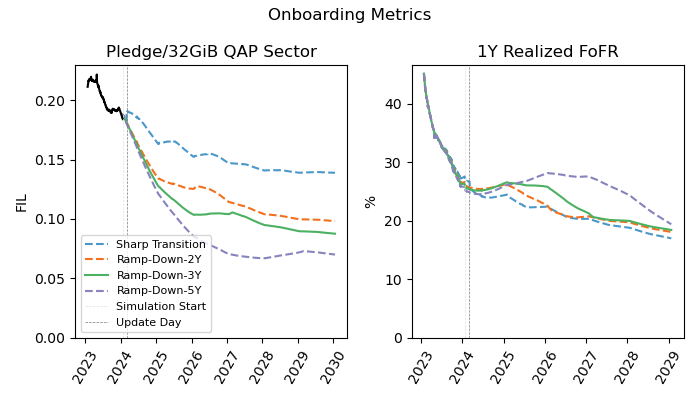

In [32]:
plot_onboarding(gammaconfig2results)

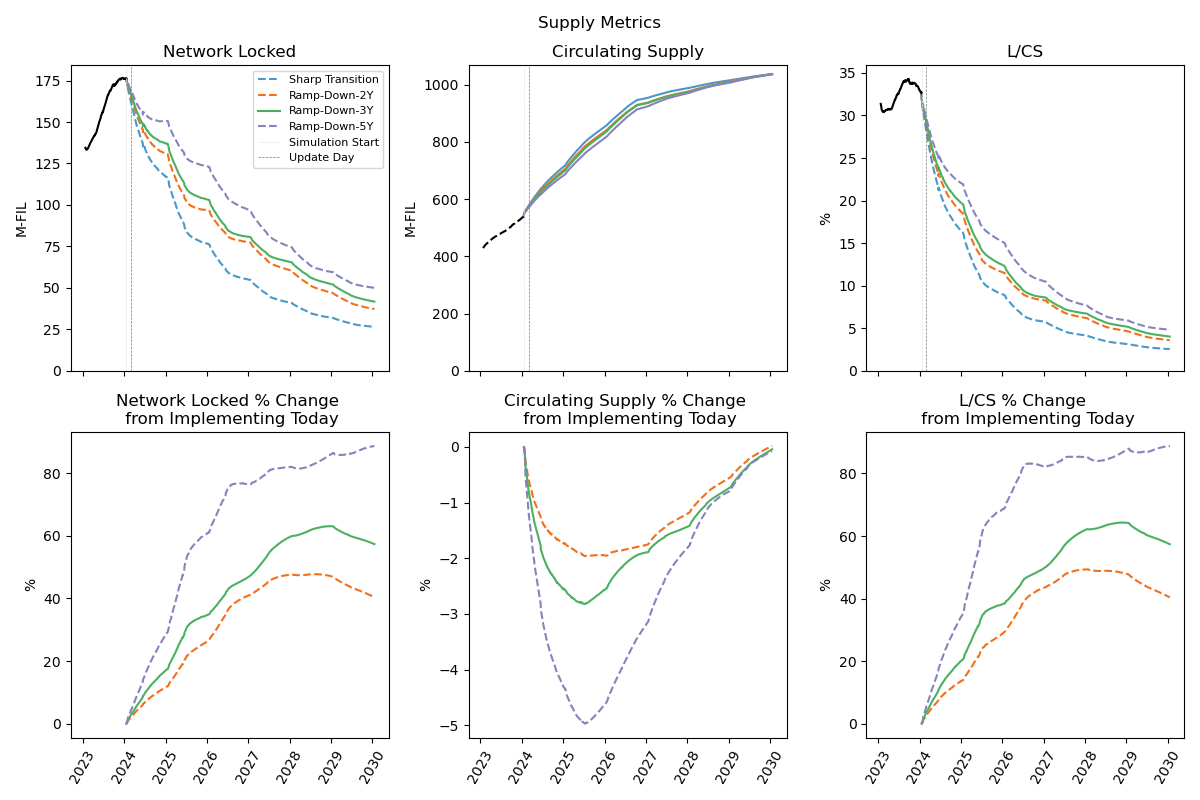

In [33]:
plot_supply(gammaconfig2results)

In [34]:
# compare the window of opportunity size for Q5 and Q20